In [5]:
#!pip install tensorflow==1.14.0

In [6]:
#!pip install keras==2.2.5

In [7]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = "0:1"

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [8]:
import gc
import warnings

#import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [9]:
site_id = 6

In [10]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train = df_train[~((df_train.meter_reading == 0) & (df_train.meter == 0))]
df_train = df_train[~((df_train.building_id == 761) & (df_train.timestamp < "2016-09-02"))]

df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

del building
gc.collect()

126

In [11]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [12]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [13]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [14]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 6 and meter 0
Preparing Site: 6 , meter: 0 , Fold: 1



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 232137 samples, validate on 77380 samples
Epoch 1/31




 - 16s - loss: 4.6677 - val_loss: 3.0945
Epoch 2/31
 - 1s - loss: 3.8035 - val_loss: 1.9297
Epoch 3/31
 - 1s - loss: 2.5759 - val_loss: 0.6786
Epoch 4/31
 - 1s - loss: 1.7227 - val_loss: 0.9027
Epoch 5/31
 - 1s - loss: 1.6222 - val_loss: 1.0819
Epoch 6/31
 - 1s - loss: 1.6061 - val_loss: 1.1213
Epoch 7/31
 - 1s - loss: 1.5911 - val_loss: 1.1337
Epoch 8/31
 - 1s - loss: 1.5736 - val_loss: 1.1386
Epoch 9/31
 - 1s - loss: 1.5395 - val_loss: 1.1441
Epoch 10/31
 - 1s - loss: 1.5172 - val_loss: 1.1468
Epoch 11/31
 - 1s - loss: 1.4893 - val_loss: 1.1504
Epoch 12/31
 - 1s - loss: 1.4686 - val_loss: 1.1548
Epoch 13/31
 - 1s - loss: 1.4430 -

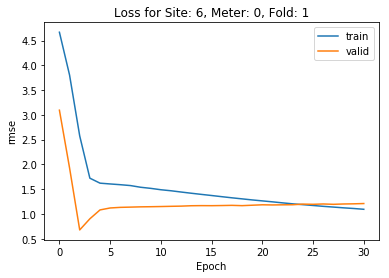

CPU times: user 17.3 s, sys: 1.11 s, total: 18.4 s
Wall time: 14 s
Preparing Site: 6 , meter: 0 , Fold: 2
Train on 232138 samples, validate on 77379 samples
Epoch 1/31
 - 2s - loss: 4.4317 - val_loss: 3.6489
Epoch 2/31
 - 1s - loss: 3.5277 - val_loss: 2.5343
Epoch 3/31
 - 1s - loss: 2.3437 - val_loss: 1.2011
Epoch 4/31
 - 1s - loss: 1.6694 - val_loss: 0.8129
Epoch 5/31
 - 1s - loss: 1.6249 - val_loss: 0.7996
Epoch 6/31
 - 1s - loss: 1.6194 - val_loss: 0.7989
Epoch 7/31
 - 1s - loss: 1.6057 - val_loss: 0.7972
Epoch 8/31
 - 1s - loss: 1.5846 - val_loss: 0.7914
Epoch 9/31
 - 1s - loss: 1.5604 - val_loss: 0.7835
Epoch 10/31
 - 1s - loss: 1.5418 - val_loss: 0.7756
Epoch 11/31
 - 1s - loss: 1.5242 - val_loss: 0.7692
Epoch 12/31
 - 1s - loss: 1.5015 - val_loss: 0.7643
Epoch 13/31
 - 1s - loss: 1.4812 - val_loss: 0.7599
Epoch 14/31
 - 1s - loss: 1.4626 - val_loss: 0.7555
Epoch 15/31
 - 1s - loss: 1.4410 - val_loss: 0.7545
Epoch 16/31
 - 1s - loss: 1.4232 - val_loss: 0.7507
Epoch 17/31
 - 1s - 

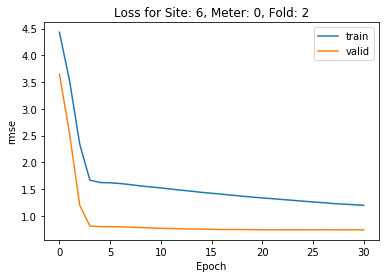

CPU times: user 16.9 s, sys: 1.12 s, total: 18.1 s
Wall time: 13.8 s
Preparing Site: 6 , meter: 0 , Fold: 3
Train on 232138 samples, validate on 77379 samples
Epoch 1/31
 - 3s - loss: 4.4453 - val_loss: 3.9823
Epoch 2/31
 - 1s - loss: 3.4343 - val_loss: 2.7170
Epoch 3/31
 - 1s - loss: 2.3715 - val_loss: 1.3165
Epoch 4/31
 - 1s - loss: 1.7695 - val_loss: 0.6293
Epoch 5/31
 - 1s - loss: 1.6703 - val_loss: 0.5616
Epoch 6/31
 - 1s - loss: 1.6537 - val_loss: 0.5619
Epoch 7/31
 - 1s - loss: 1.6348 - val_loss: 0.5641
Epoch 8/31
 - 1s - loss: 1.6116 - val_loss: 0.5657
Epoch 9/31
 - 1s - loss: 1.5999 - val_loss: 0.5665
Epoch 10/31
 - 1s - loss: 1.5793 - val_loss: 0.5666
Epoch 11/31
 - 1s - loss: 1.5641 - val_loss: 0.5668
Epoch 12/31
 - 1s - loss: 1.5466 - val_loss: 0.5668
Epoch 13/31
 - 1s - loss: 1.5246 - val_loss: 0.5661
Epoch 14/31
 - 1s - loss: 1.5100 - val_loss: 0.5642
Epoch 15/31
 - 1s - loss: 1.4912 - val_loss: 0.5600
Epoch 16/31
 - 1s - loss: 1.4802 - val_loss: 0.5490
Epoch 17/31
 - 1s 

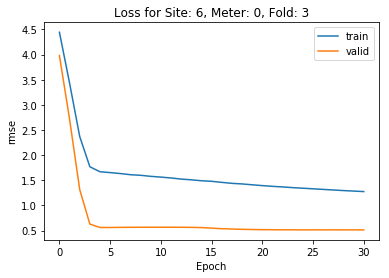

CPU times: user 17.7 s, sys: 1.01 s, total: 18.7 s
Wall time: 14.5 s
Preparing Site: 6 , meter: 0 , Fold: 4
Train on 232138 samples, validate on 77379 samples
Epoch 1/31
 - 3s - loss: 4.0317 - val_loss: 5.3845
Epoch 2/31
 - 1s - loss: 3.2910 - val_loss: 4.3049
Epoch 3/31
 - 1s - loss: 2.2103 - val_loss: 2.9148
Epoch 4/31
 - 1s - loss: 1.4624 - val_loss: 2.0687
Epoch 5/31
 - 1s - loss: 1.3642 - val_loss: 1.8986
Epoch 6/31
 - 1s - loss: 1.3434 - val_loss: 1.8649
Epoch 7/31
 - 1s - loss: 1.3230 - val_loss: 1.8514
Epoch 8/31
 - 1s - loss: 1.2988 - val_loss: 1.8375
Epoch 9/31
 - 1s - loss: 1.2760 - val_loss: 1.8334
Epoch 10/31
 - 1s - loss: 1.2520 - val_loss: 1.8280
Epoch 11/31
 - 1s - loss: 1.2272 - val_loss: 1.8217
Epoch 12/31
 - 1s - loss: 1.2063 - val_loss: 1.8116
Epoch 13/31
 - 1s - loss: 1.1816 - val_loss: 1.8013
Epoch 14/31
 - 1s - loss: 1.1602 - val_loss: 1.7883
Epoch 15/31
 - 1s - loss: 1.1382 - val_loss: 1.7778
Epoch 16/31
 - 1s - loss: 1.1157 - val_loss: 1.7601
Epoch 17/31
 - 1s 

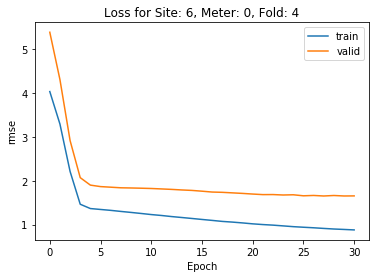

CPU times: user 18.4 s, sys: 1.06 s, total: 19.5 s
Wall time: 15.2 s

CV RMSE for Site: 6 and Meter: 0 is 1.2444892097089606

CV RMSE for Site: 6 is 1.2444892097089606


In [15]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(16, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(2, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=31, batch_size=1000, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        %time pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [18]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)